In [ ]:
!pip install xgboost

In [ ]:
!pip install pydub

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Genres: ['Electronic', 'classical', 'blues', 'country', 'metal', 'reggae', 'hiphop', 'rock', 'disco', 'jazz', 'pop', 'Experimental']


<ipython-input-5-f3e0baa39638>:71: UserWarning: PySoundFile failed. Trying audioread instead.
  _, _ = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Skipping problematic file: /content/drive/MyDrive/Data/genres_original/jazz/jazz.00054.wav
Total valid files: 1199 out of 1200
Starting CNN training on segments...
Epoch [1/60], Train Loss: 2.3179, Train Acc: 0.2058, Val Loss: 2.0848, Val Acc: 0.3574
Epoch [2/60], Train Loss: 2.0739, Train Acc: 0.3369, Val Loss: 1.9162, Val Acc: 0.4167
Epoch [3/60], Train Loss: 1.9583, Train Acc: 0.3806, Val Loss: 1.8100, Val Acc: 0.4704
Epoch [4/60], Train Loss: 1.8718, Train Acc: 0.4136, Val Loss: 1.7196, Val Acc: 0.4870
Epoch [5/60], Train Loss: 1.8022, Train Acc: 0.4478, Val Loss: 1.6541, Val Acc: 0.5296
Epoch [6/60], Train Loss: 1.7556, Train Acc: 0.4557, Val Loss: 1.6024, Val Acc: 0.5296
Epoch [7/60], Train Loss: 1.6933, Train Acc: 0.4962, Val Loss: 1.5535, Val Acc: 0.5519
Epoch [8/60], Train Loss: 1.6486, Train Acc: 0.5022, Val Loss: 1.5367, Val Acc: 0.5556
Epoch [9/60], Train Loss: 1.6072, Train Acc: 0.5141, Val Loss: 1.4567, Val Acc: 0.6222
Epoch [10/60], Train Loss: 1.5676, Train Acc: 0.5379,

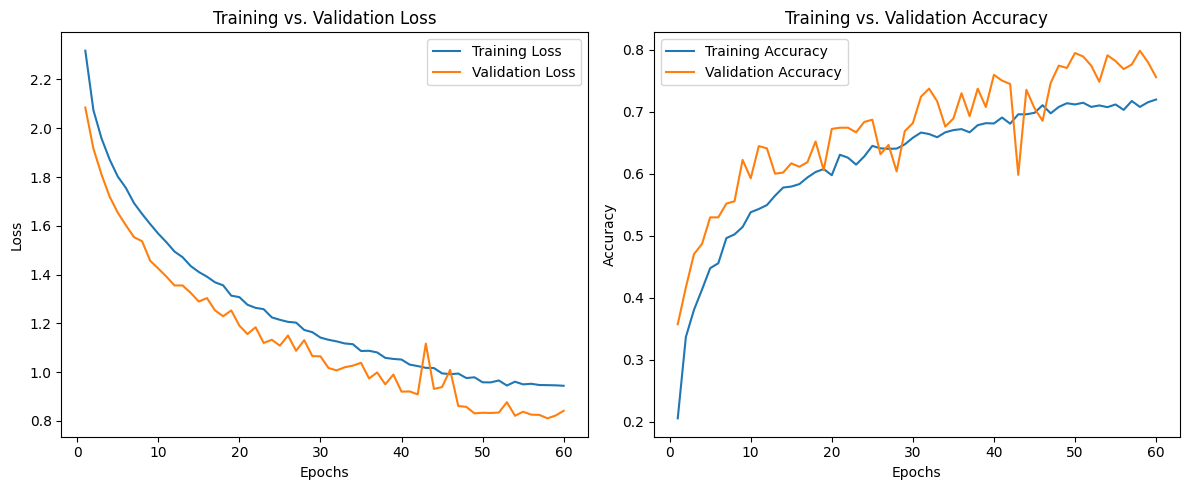

Training the XGBoost classifier on combined segment-level features...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:24:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report (File Level):
              precision    recall  f1-score   support

  Electronic       0.73      0.73      0.73        15
Experimental       0.64      0.60      0.62        15
       blues       0.86      0.80      0.83        15
   classical       0.82      0.93      0.88        15
     country       0.80      0.80      0.80        15
       disco       0.76      0.87      0.81        15
      hiphop       0.87      0.87      0.87        15
        jazz       0.81      0.87      0.84        15
       metal       0.92      0.80      0.86        15
         pop       1.00      0.73      0.85        15
      reggae       0.87      0.87      0.87        15
        rock       0.50      0.60      0.55        15

    accuracy                           0.79       180
   macro avg       0.80      0.79      0.79       180
weighted avg       0.80      0.79      0.79       180

XGBoost Confusion Matrix (File Level):
[[11  4  0  0  0  0  0  0  0  0  0  0]
 [ 4  9  0 

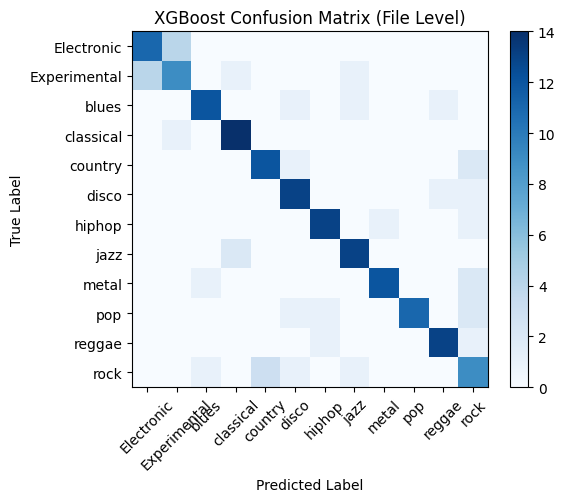

Combined model saved as 'combined_audio_model_bundle.pt'.


In [ ]:
#Loada öll imports
import os
import numpy as np
import librosa
from pydub import AudioSegment
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
import matplotlib.pyplot as plt
import xgboost as xgb

#Loada gögnin ú drive'i
try:
    from google.colab import drive
    drive.mount('/content/drive')
    audio_path = '/content/drive/MyDrive/Data/genres_original'
except ImportError:
    audio_path = '/path/to/genres_original'

#Safna lista af öllum tónlistarstefnum, if setningin er útaf file'i sem kemur þegar maður uploadar frá macca
genres = [g for g in os.listdir(audio_path) if not g.startswith('.') and os.path.isdir(os.path.join(audio_path, g))]
print("Genres:", genres)

#Skilgreina staðsetningu file'a og "Nöfn" þeirra
file_paths = []
labels = []
for genre in genres:
    genre_path = os.path.join(audio_path, genre)
    for file in os.listdir(genre_path):
        if file.endswith('.wav'):
            file_paths.append(os.path.join(genre_path, file))
            labels.append(genre)

#Gefur hverja tónlistarstefnu heiltölu, semsagt 1-12
genre_to_idx = {genre: idx for idx, genre in enumerate(sorted(genres))}
labels = [genre_to_idx[label] for label in labels]


def load_audio_pydub(file_path, sr, duration):
    #Reyna að lesa með pydub
    try:
        audio = AudioSegment.from_file(file_path)
    except Exception as e:
        raise RuntimeError(f"Failed to load {file_path} with pydub: {e}")

    #Lesa hljóðskránna
    samples = np.array(audio.get_array_of_samples(), dtype=np.float32)

    #Sækja bein gögn, hvort sem það sé með eina rás eða margar
    if audio.channels > 1:
        samples = samples.reshape((-1, audio.channels))
        samples = samples.mean(axis=1)
    if audio.frame_rate != sr:
        samples = librosa.resample(samples, orig_sr=audio.frame_rate, target_sr=sr)

    #Fullvissa að allsé að nota sömu tíðni (sr)
    expected_samples = int(sr * duration)
    if len(samples) < expected_samples:
        samples = np.pad(samples, (0, expected_samples - len(samples)), mode='constant')
    else:
        samples = samples[:expected_samples]
    return samples, sr

#Þetta fall þarf vegna þess það er eitt lag í datasettinu sem er ekki hægt að keyra
#Kemur í veg fyrir að allt stoppi. takk chat.
def is_valid_audio(file_path, sr=22050, duration=30):
    """Check whether the audio file can be loaded with librosa or via the fallback."""
    try:
        _, _ = librosa.load(file_path, sr=sr, duration=duration)
        return True
    except Exception:
        try:
            _, _ = load_audio_pydub(file_path, sr=sr, duration=duration)
            return True
        except Exception:
            return False

#Síar út gögn sem við viljum sleppa
valid_file_paths = []
valid_labels = []
for fp, lab in zip(file_paths, labels):
    if is_valid_audio(fp, sr=22050, duration=30):
        valid_file_paths.append(fp)
        valid_labels.append(lab)
    else:
        print(f"Skipping problematic file: {fp}")

print(f"Total valid files: {len(valid_file_paths)} out of {len(file_paths)}")

#Splittar í train (70%), test (15%) og validation set (15%).
#Ath að hérna er ekki ennþá búið að splitta lögin niður.
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    valid_file_paths, valid_labels, test_size=0.3, stratify=valid_labels, random_state=42
)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

#Preprocessar tónlistina í log-mel spectogram
def preprocess_audio(y, sr, n_mels):
    """
    Compute mel-spectrogram, convert to log scale and normalize.
    Returns a numpy array with an added channel dimension.
    """
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    log_mel_spec = (log_mel_spec - log_mel_spec.mean()) / (log_mel_spec.std() + 1e-6)
    log_mel_spec = np.expand_dims(log_mel_spec, axis=0)
    return log_mel_spec

#Fall sem bútar niður tónlistina niður í 10 sekúndna búta
class SegmentedAudioDataset(Dataset):
    def __init__(self, file_paths, labels, sr=22050, n_mels=128, full_duration=30, segment_duration=10):
        self.file_paths = file_paths
        self.labels = labels
        self.sr = sr
        self.n_mels = n_mels
        self.full_duration = full_duration
        self.segment_duration = segment_duration
        self.full_samples = sr * full_duration
        self.segment_samples = sr * segment_duration

        #mapping[file_index, segment_index]
        self.mapping = []
        for i, _ in enumerate(file_paths):
            num_segments = int(np.ceil(full_duration / segment_duration))
            for j in range(num_segments):
                self.mapping.append((i, j))

    def __len__(self):
        return len(self.mapping)

    #Nær í eitt data sample
    def __getitem__(self, idx):
      #Ná í slóð og merkingu
        file_idx, seg_idx = self.mapping[idx]
        file_path = self.file_paths[file_idx]
        label = self.labels[file_idx]

        #Ná í alla skránna sem eitt bil
        try:
            y, sr_ = librosa.load(file_path, sr=self.sr, duration=self.full_duration)

            #Gæta þess að hljóðið sé full_samples langt
            if len(y) < self.full_samples:
                y = np.pad(y, (0, self.full_samples - len(y)), mode='constant')
            else:
                y = y[:self.full_samples]
        except Exception as e:
            print(f"Librosa load failed for {file_path} with error: {e}. Falling back to pydub...")
            y, sr_ = load_audio_pydub(file_path, sr=self.sr, duration=self.full_duration)

        #Sækja réttan 10 sek bút úr laginu
        start = seg_idx * self.segment_samples
        end = start + self.segment_samples
        if end > len(y):
            y_segment = np.pad(y[start:], (0, end - len(y)), mode='constant')
        else:
            y_segment = y[start:end]

        #Breyta búti í spectogram
        spec = preprocess_audio(y_segment, sr_, self.n_mels)
        spec_tensor = torch.tensor(spec, dtype=torch.float)
        return spec_tensor, torch.tensor(label, dtype=torch.long)

#CNN módel (módel 1)
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__() #initialization

        #Blokka 1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        #Blokka 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        #Blokka 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        #Lokaaðgerðir fyrir classification
        self.pool = nn.MaxPool2d(2)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.25) #Búinn að testa, bæti kannski við lækkun á dropout rate
        self.fc = nn.Linear(128, num_classes)

    #tekur inn tensor. x = (batch_size, 1, n_mels, time_steps)
    def forward_features(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = self.global_avg_pool(x)
        return x.view(x.size(0), -1)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.dropout(x)
        return self.fc(x)


#Telur fjölda laga (tónlist) í hverri tónlistarstefnu
def compute_class_weights(labels):
    counts = np.bincount(labels)
    weights = [sum(counts) / c for c in counts]
    return torch.tensor(weights, dtype=torch.float)

#Hyperparametrar
batch_size = 32
num_epochs = 60
learning_rate = 1e-4
sr = 22050
n_mels = 128
full_duration = 30
segment_duration = 10
num_classes = len(genre_to_idx)

#Búa til train og val dataset
train_dataset = SegmentedAudioDataset(train_paths, train_labels, sr, n_mels, full_duration, segment_duration)
val_dataset = SegmentedAudioDataset(val_paths, val_labels, sr, n_mels, full_duration, segment_duration)

#vinna í batches
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

#Veit ekki hvort þetta þarf til þess að keyra á GPU inná colab
#en þetta var notað í síðasta CNN verkefni okkar og ég ákvað að geyma þetta
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioCNN(num_classes=num_classes).to(device) #skilgreini módel 1 klasann
class_weights = compute_class_weights(train_labels).to(device) #reikna flokksþyngdir
criterion = nn.CrossEntropyLoss(weight=class_weights) #Loss
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) #weight decay er notað en því var aldrei breytt
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5) #optimizear learning rate

#Til þess að getað teiknað upp accuracy og loss
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []


print("Starting CNN training on segments...")
best_val_acc = 0.0 #til geymslu þegar valið er besta epoch

#Hér byrjar epoch lærdómurinn
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels_batch in train_loader:
        inputs, labels_batch = inputs.to(device), labels_batch.to(device)
        optimizer.zero_grad() #núllstilla gradienta
        outputs = model(inputs) #keyra módel á inputs
        loss = criterion(outputs, labels_batch)
        loss.backward() #reiknar gradient
        optimizer.step() #uppfærir þyngdir

        #safna gögn um módelið
        epoch_train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels_batch).sum().item()
        train_total += labels_batch.size(0)
    #Reikna loss og accuracy
    epoch_train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / train_total
    train_loss_history.append(epoch_train_loss)
    train_acc_history.append(train_accuracy)

    #slekkur á dropout
    model.eval()
    epoch_val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad(): #hættir gradient útreikninga þegar komið er hingað
        #köllu ekki á backwards propigation né step heldur einungis láta módelið classify'a
        #Reikna loss og acc
        for inputs, labels_batch in val_loader:
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels_batch)
            epoch_val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels_batch).sum().item()
            val_total += labels_batch.size(0)
    epoch_val_loss /= len(val_loader.dataset)
    val_accuracy = val_correct / val_total
    val_loss_history.append(epoch_val_loss)
    val_acc_history.append(val_accuracy)
    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    #Stjórnar lærsluhraða og geymir besta módelið
    scheduler.step(epoch_val_loss)
    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'best_cnn_model.pt')

#Plottar upp öll epochin
epochs_arr = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_arr, train_loss_history, label="Training Loss")
plt.plot(epochs_arr, val_loss_history, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(epochs_arr, train_acc_history, label="Training Accuracy")
plt.plot(epochs_arr, val_acc_history, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

#Ná í allt sem XGBoost notar til að þjálfa,
#svosem CNN features, MFCC, tempo osg
def extract_segment_combined_features(
    model,
    file_path,
    sr=22050,
    n_mels=128,
    n_mfcc=20,
    full_duration=30,
    segment_duration=10,
    device='cpu'
):
    full_samples = sr * full_duration
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=full_duration)
        if len(y) < full_samples:
            y = np.pad(y, (0, full_samples - len(y)), mode='constant')
        else:
            y = y[:full_samples]
    except Exception as e:
        print(f"Error loading {file_path} with librosa: {e}. Falling back to pydub.")
        y, _ = load_audio_pydub(file_path, sr=sr, duration=full_duration)

    #búta niður lögin
    segment_samples = sr * segment_duration
    num_segments = int(np.ceil(full_duration / segment_duration))
    combined_features = []
    for seg_idx in range(num_segments):
        start = seg_idx * segment_samples
        end = start + segment_samples
        if end > len(y):
            seg_audio = np.pad(y[start:], (0, end - len(y)), mode='constant')
        else:
            seg_audio = y[start:end]
        length_in_samples = seg_audio.shape[0]

        #Hér eru allar auka breytur reiknaðar fyrir XGBoost
        #Chroma
        chroma_stft = librosa.feature.chroma_stft(y=seg_audio, sr=sr)
        chroma_stft_mean = np.mean(chroma_stft)
        chroma_stft_var = np.var(chroma_stft)

        #RMS
        rms = librosa.feature.rms(y=seg_audio)
        rms_mean = np.mean(rms)
        rms_var = np.var(rms)

        #Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=seg_audio, sr=sr)
        spectral_centroid_mean = np.mean(spectral_centroid)
        spectral_centroid_var = np.var(spectral_centroid)

        #Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=seg_audio, sr=sr)
        spectral_bandwidth_mean = np.mean(spectral_bandwidth)
        spectral_bandwidth_var = np.var(spectral_bandwidth)

        #Rolloff
        rolloff = librosa.feature.spectral_rolloff(y=seg_audio, sr=sr)
        rolloff_mean = np.mean(rolloff)
        rolloff_var = np.var(rolloff)

        #Zero Crossing Rate
        zcr = librosa.feature.zero_crossing_rate(seg_audio)
        zcr_mean = np.mean(zcr)
        zcr_var = np.var(zcr)

        manual_feats = np.array([
            length_in_samples,
            chroma_stft_mean, chroma_stft_var,
            rms_mean, rms_var,
            spectral_centroid_mean, spectral_centroid_var,
            spectral_bandwidth_mean, spectral_bandwidth_var,
            rolloff_mean, rolloff_var,
            zcr_mean, zcr_var
        ], dtype=np.float32)

        #mfcc mean feature'a
        mfcc = librosa.feature.mfcc(y=seg_audio, sr=sr, n_mfcc=n_mfcc)
        mfcc_mean = np.mean(mfcc, axis=1) #shape: (n_mfcc,)

        #Náð í featura frá fyrri módeli
        spec = preprocess_audio(seg_audio, sr, n_mels)
        spec_tensor = torch.tensor(spec, dtype=torch.float).unsqueeze(0).to(device)
        with torch.no_grad():
            cnn_feat = model.forward_features(spec_tensor)
        cnn_feat = cnn_feat.cpu().numpy().squeeze(0)

        #sameina (concatenate) feature'a
        combined = np.concatenate([manual_feats, mfcc_mean, cnn_feat])
        combined_features.append(combined)
    return combined_features

#Fall sem nær í feature'a
def get_combined_features(file_list, labels_list, model, sr, n_mels, n_mfcc, full_duration, segment_duration, device):
    all_feats = []
    all_labels = []
    for fp, lab in zip(file_list, labels_list):
        seg_feats = extract_segment_combined_features(
            model, fp, sr, n_mels, n_mfcc, full_duration, segment_duration, device
        )
        all_feats.extend(seg_feats)
        all_labels.extend([lab] * len(seg_feats))
    return np.array(all_feats), np.array(all_labels)

#Hlaða inn CNN módelið sem fékk hæsta validation acc
model.load_state_dict(torch.load('best_cnn_model.pt'))
model.eval()

#Nær í gögn fyrir train og validation sets
X_xgb_train, y_xgb_train = get_combined_features(
    train_paths + val_paths,
    train_labels + val_labels,
    model, sr, n_mels, n_mfcc=20,
    full_duration=full_duration,
    segment_duration=segment_duration,
    device=device
)

#Nær í gögn fyrir test sets
X_xgb_test_segments, y_xgb_test_segments = get_combined_features(
    test_paths,
    test_labels,
    model, sr, n_mels, n_mfcc=20,
    full_duration=full_duration,
    segment_duration=segment_duration,
    device=device
)

#Kannski bæta við fleiri print skipanir meðan XGBoost er að þjálfa
print("Training the XGBoost classifier on combined segment-level features...")

#hyperparams fyrir XGBoost
xgb_clf = xgb.XGBClassifier(
    objective="multi:softprob",
    n_estimators=250,
    max_depth=5,
    learning_rate=0.15,
    subsample=0.7,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
xgb_clf.fit(X_xgb_train, y_xgb_train)#líkanið þjálfað á train og val set

#Majority voting útfrá öllum þremur seniðum
file_level_preds = []
for fp, true_label in zip(test_paths, test_labels):
    seg_feats = extract_segment_combined_features(
        model, fp, sr, n_mels, n_mfcc=20,
        full_duration=full_duration, segment_duration=segment_duration,
        device=device
    )
    seg_feats = np.array(seg_feats)
    seg_preds = xgb_clf.predict(seg_feats)
    vote = np.bincount(seg_preds).argmax()
    file_level_preds.append(vote)

#Prentar confusion matrix og flokkunarskýrslu
print("XGBoost Classification Report (File Level):")
print(classification_report(test_labels, file_level_preds,
      target_names=[g for g, _ in sorted(genre_to_idx.items(), key=lambda x: x[1])]))
cm = confusion_matrix(test_labels, file_level_preds)
print("XGBoost Confusion Matrix (File Level):")
print(cm)

#Matplotlib confusion matrix
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("XGBoost Confusion Matrix (File Level)")
plt.colorbar()
tick_marks = np.arange(len(genre_to_idx))
plt.xticks(tick_marks, [g for g, _ in sorted(genre_to_idx.items(), key=lambda x: x[1])], rotation=45)
plt.yticks(tick_marks, [g for g, _ in sorted(genre_to_idx.items(), key=lambda x: x[1])])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

#savear allt módelið
bundle = {
    'cnn_model_state_dict': model.state_dict(),
    'genre_to_idx': genre_to_idx,
    'xgboost_model': xgb_clf,
    'cnn_architecture': 'AudioCNN',
    'sr': sr,
    'n_mels': n_mels,
    'full_duration': full_duration,
    'segment_duration': segment_duration,
    'n_mfcc': 20
}
torch.save(bundle, 'combined_audio_model_bundle.pt')
print("Combined model saved as 'combined_audio_model_bundle.pt'.")
